# Exploring Ensemble Methods

In this homework we will explore the use of boosting. For this assignment, we will use the pre-implemented gradient boosted trees in Graphlab-Create. You will:

- Use SFrames to do some feature engineering.
- Train a boosted ensemble of decision-trees (gradient boosted trees) on the lending club dataset.
- Predict whether a loan will default along with prediction probabilities (on a validation set).
- Evaluate the trained model and compare it with a baseline.
- Find the most positive and negative loans using the learned model.
- Explore how the number of trees influences classification performance.

Load the Lending Club dataset

In [1]:
import graphlab
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

This non-commercial license of GraphLab Create for academic use is assigned to santosh.chilkunda@gmail.com and will expire on July 20, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1482742066.log


In [2]:
loans = graphlab.SFrame('lending-club-data.gl/')

Exploring some features

In [3]:
loans.column_names()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'is_inc_v',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'not_compliant',
 'status',
 'inactive_loans',
 'bad_loans',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'delinq_2yrs_zero',
 'pub_rec

Modifying the target column

In [4]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x: +1 if(x==0) else -1)
loans = loans.remove_column('bad_loans')

Selecting features

In [5]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [6]:
loans = loans[features + [target]]

Skipping observations with missing values

In [7]:
np.shape(loans)

(122607, 25)

In [8]:
loans = loans.dropna()
np.shape(loans)

(122578, 25)

Make sure the classes are balanced

In [9]:
safe_loans_data = loans[loans['safe_loans'] == +1]
risky_loans_data = loans[loans['safe_loans'] == -1]

pctage = (len(risky_loans_data) / float(len(safe_loans_data)))
safe_loans_data2 = safe_loans_data.sample(pctage, seed=1)

print "num safe loans:", len(safe_loans_data2)
print "num risky loans:", len(risky_loans_data)

loans_data = risky_loans_data.append(safe_loans_data2)

num safe loans: 23356
num risky loans: 23147


One-hot encoding

In [10]:
categorical_variables = []
for feat_name, feat_type in zip(loans_data.column_names(), loans_data.column_types()):
    if feat_type == str:
        categorical_variables.append(feat_name)

for feature in categorical_variables:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)

    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

loans_data.column_names()

['sub_grade_num',
 'short_emp',
 'emp_length_num',
 'dti',
 'payment_inc_ratio',
 'delinq_2yrs',
 'delinq_2yrs_zero',
 'inq_last_6mths',
 'last_delinq_none',
 'last_major_derog_none',
 'open_acc',
 'pub_rec',
 'pub_rec_zero',
 'revol_util',
 'total_rec_late_fee',
 'int_rate',
 'total_rec_int',
 'annual_inc',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'safe_loans',
 'grade.A',
 'grade.B',
 'grade.C',
 'grade.D',
 'grade.E',
 'grade.F',
 'grade.G',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT',
 'purpose.car',
 'purpose.credit_card',
 'purpose.debt_consolidation',
 'purpose.home_improvement',
 'purpose.house',
 'purpose.major_purchase',
 'purpose.medical',
 'purpose.moving',
 'purpose.other',
 'purpose.small_business',
 'purpose.vacation',
 'purpose.wedding']

Split data into training and validation

In [11]:
train_data, validation_data = loans_data.random_split(0.8, seed=1)

Convert the SFrame into a numpy data matrix

In [12]:
train_data_target = train_data['safe_loans']
train_data = train_data.remove_column('safe_loans')
train_data_np = train_data.to_numpy()
train_data_target_np = train_data_target.to_numpy()

Gradient boosted tree classifier

In [13]:
gbc_model_5 = GradientBoostingClassifier(n_estimators=5, max_depth=6).fit(train_data_np, train_data_target_np)

Making predictions

In [14]:
validation_safe_loans = validation_data[validation_data['safe_loans'] == +1]
validation_risky_loans = validation_data[validation_data['safe_loans'] == -1]

sample_validation_data_safe = validation_safe_loans[0:2]
sample_validation_data_risky = validation_risky_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)

In [15]:
sample_validation_data_target = sample_validation_data['safe_loans']
sample_validation_data = sample_validation_data.remove_column('safe_loans')
sample_validation_data_np = sample_validation_data.to_numpy()
sample_validation_data_target_np = sample_validation_data_target.to_numpy()

# What percentage of the predictions on sample_validation_data did model_5 get correct?

In [16]:
gbc_model_5.predict(sample_validation_data_np)

array([ 1,  1, -1,  1])

In [17]:
sample_validation_data_target_np

array([ 1,  1, -1, -1])

Prediction Probabilities

# Which loan has the highest probability of being classified as a safe loan?

In [18]:
gbc_model_5.predict_proba(sample_validation_data_np)

array([[ 0.41642331,  0.58357669],
       [ 0.46949689,  0.53050311],
       [ 0.53807792,  0.46192208],
       [ 0.39591639,  0.60408361]])

In [19]:
gbc_model_5.score(sample_validation_data_np, sample_validation_data_target_np)

0.75

# What is the number of false positives on the validation_data?

In [20]:
print gbc_model_5.predict(sample_validation_data_np)
print sample_validation_data_target_np

[ 1  1 -1  1]
[ 1  1 -1 -1]


- False negatives: Assume a cost of $10,000 per false negative.
- False positives: Assume a cost of $20,000 per false positive.
- Calculate the cost of mistakes made by model_5 on the validation_data.

In [21]:
validation_safe_loans = validation_data[validation_data['safe_loans'] == +1]
validation_risky_loans = validation_data[validation_data['safe_loans'] == -1]

validation_safe_data = validation_safe_loans.remove_column('safe_loans').to_numpy()
validation_risky_data = validation_risky_loans.remove_column('safe_loans').to_numpy()

In [22]:
validation_risky_prediction = gbc_model_5.predict(validation_risky_data)
err = np.array(validation_risky_prediction != -1)
num_false_positives = np.sum(err)
print "False positives:", num_false_positives

validation_safe_prediction = gbc_model_5.predict(validation_safe_data)
err = np.array(validation_safe_prediction != +1)
num_false_negatives = np.sum(err)
print "False negatives:", num_false_negatives

print "Total number of observations:", len(validation_data)

False positives: 1652
False negatives: 1491
Total number of observations: 9284


# Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (model_5) as evaluated on the validation_set?

In [23]:
cost = num_false_positives*20000 + num_false_negatives*10000
print cost

47950000


Most positive & negative loans.

In [24]:
validation_data2 = validation_data
validation_data_np = validation_data2.remove_column('safe_loans').to_numpy()

In [25]:
pred_prob = gbc_model_5.predict_proba(validation_data_np)
validation_data2['pred_prob'] = pred_prob[:,1]

In [26]:
validation_data2 = validation_data2.sort('pred_prob')

# What grades are the top 5 loans?

In [27]:
validation_data2.tail(5)

sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths
0.4,0,11,2.08,3.8251,0,1,0
0.4,0,5,7.82,1.12313,0,1,1
0.4,0,11,9.51,5.65833,0,1,0
0.2,0,11,10.85,3.21647,0,1,1
0.4,0,4,12.73,12.167,0,1,1
last_delinq_none,last_major_derog_none,open_acc,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate
1,1,7,0,1,9.5,0.0,6.62
1,1,11,0,1,8.3,0.0,5.99
1,1,32,0,1,7.9,0.0,6.97
1,1,18,0,1,19.6,0.0,6.03


Repeat this exercise to find the 5 loans (in the validation_data) with the lowest probability of being predicted as a safe loan.

In [28]:
validation_data2.head(5)

sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths
0.8,1,1,7.37,16.6207,0,1,1
0.8,0,2,8.66,17.6251,0,1,0
1.0,0,3,8.53,14.628,0,1,0
0.8,0,9,8.54,7.48113,0,1,2
0.2,0,11,11.21,4.23624,0,1,3
last_delinq_none,last_major_derog_none,open_acc,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate
1,1,8,0,1,32.6,24.93,16.29
1,1,8,0,1,64.4,92.52,16.29
1,1,6,0,1,79.5,54.709,14.22
0,1,8,0,1,51.3,0.0,16.29


Effects of adding more trees

In [29]:
gbc_model_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6).fit(train_data_np, train_data_target_np)
gbc_model_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6).fit(train_data_np, train_data_target_np)
gbc_model_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6).fit(train_data_np, train_data_target_np)
gbc_model_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6).fit(train_data_np, train_data_target_np)
gbc_model_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6).fit(train_data_np, train_data_target_np)

Evaluate the accuracy of the 10, 50, 100, 200, and 500 tree models on the validation_data.

# Quiz Question: Which model has the best accuracy on the validation_data?

# Quiz Question: Is it always true that the model with the most trees will perform best on test data?

In [31]:
train_data, validation_data = loans_data.random_split(0.8, seed=1)
validation_data_target = validation_data['safe_loans']
validation_data = validation_data.remove_column('safe_loans')
validation_data_target_np = validation_data_target.to_numpy()
validation_data_np = validation_data.to_numpy()

print "model 10 accuracy:", gbc_model_10.score(validation_data_np, validation_data_target_np)
print "model 50 accuracy:", gbc_model_50.score(validation_data_np, validation_data_target_np)
print "model 100 accuracy:", gbc_model_100.score(validation_data_np, validation_data_target_np)
print "model 200 accuracy:", gbc_model_200.score(validation_data_np, validation_data_target_np)
print "model 500 accuracy:", gbc_model_500.score(validation_data_np, validation_data_target_np)

model 10 accuracy: 0.665338216286
model 50 accuracy: 0.681818181818
model 100 accuracy: 0.689250323137
model 200 accuracy: 0.69043515726
model 500 accuracy: 0.688496337785


In [32]:
model_10_train_err = (1-gbc_model_10.score(train_data_np, train_data_target_np))
model_50_train_err = (1-gbc_model_50.score(train_data_np, train_data_target_np))
model_100_train_err = (1-gbc_model_100.score(train_data_np, train_data_target_np))
model_200_train_err = (1-gbc_model_200.score(train_data_np, train_data_target_np))
model_500_train_err = (1-gbc_model_500.score(train_data_np, train_data_target_np))

model_10_valid_err = (1-gbc_model_10.score(validation_data_np, validation_data_target_np))
model_50_valid_err = (1-gbc_model_50.score(validation_data_np, validation_data_target_np))
model_100_valid_err = (1-gbc_model_100.score(validation_data_np, validation_data_target_np))
model_200_valid_err = (1-gbc_model_200.score(validation_data_np, validation_data_target_np))
model_500_valid_err = (1-gbc_model_500.score(validation_data_np, validation_data_target_np))

print "model 10 training error:", model_10_train_err, " validation error:", model_10_valid_err
print "model 50 training error:", model_50_train_err, " validation error:", model_50_valid_err
print "model 100 training error:", model_100_train_err, " validation error:", model_100_valid_err
print "model 200 training error:", model_200_train_err, " validation error:", model_200_valid_err
print "model 500 training error:", model_500_train_err, " validation error:", model_500_valid_err

model 10 training error: 0.32891802574  validation error: 0.334661783714
model 50 training error: 0.283242429942  validation error: 0.318181818182
model 100 training error: 0.253633896666  validation error: 0.310749676863
model 200 training error: 0.213358768371  validation error: 0.30956484274
model 500 training error: 0.136328219458  validation error: 0.311503662215


In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [34]:
training_errors = [model_10_train_err, model_50_train_err, model_100_train_err, model_200_train_err, model_500_train_err]
validation_errors = [model_10_valid_err, model_50_valid_err, model_100_valid_err, model_200_valid_err, model_500_valid_err]

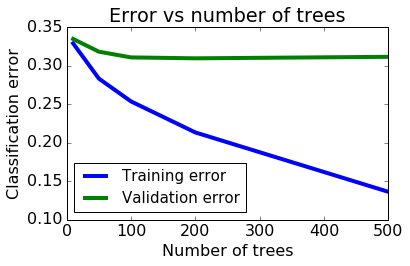

In [35]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')